In [41]:
from brainiak.isc import isc,bootstrap_isc,compute_summary_statistic
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn.image import index_img,concat_imgs,resample_to_img,smooth_img,math_img
from nilearn.masking import apply_mask,unmask
from nilearn import plotting as niplt
import os
import time
from scipy.stats import mode as statmode
import matplotlib.pyplot as plt
import pickle
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from skimage.measure import label as dolabel
from skimage.measure import regionprops

In [42]:
froot = '/data00/layerfMRI/'
av_mask_img = froot + 'masks/average_mask_mni.nii.gz'
Nvox = int(np.sum(apply_mask(av_mask_img,av_mask_img)))

In [43]:
logsumm = (pd
           .read_csv(froot+ 'logs/log_summary.csv')
           .assign(fmri = lambda d:
                   froot + 
                   'regdata/sub_' + d['subject'].apply(lambda n: '{:02d}'.format(n)) +
                   '/ses_' + d['session'].apply(lambda n: '{:02d}'.format(n)) +
                   '/func/task_' + d['task'].apply(lambda n: '{:01d}'.format(n)) +
                   '_run_' + d['run'].apply(lambda n: '{:01d}'.format(n)) +
                   '_4D_MNI.nii.gz'
                  )
           .assign(fmri_missing = lambda d : d['fmri'].apply(lambda s: os.path.isfile(s) != True))
           
          )

Nsub = logsumm['subject'].nunique()

In [44]:
movies = {}
for m,df in logsumm.groupby('Type'):
    movies[m] = list(df['Title'].unique())

In [116]:
logsumm.sort_values('subject')['subject'].unique()


array([ 2,  3,  5,  6,  8,  9, 10, 11, 12, 14])

In [128]:
data = {}
data_mov = {}
data_mov_run = {}

c = 'M'

for c in ['M','S']:
    data_mov[c] = {}
    data_mov_run[c] = {}


    for im,movfile in enumerate(movies[c]):

        mov = movfile.split('.')[0]
        data_mov_run[c][mov] = {}

        for run,rdf in logsumm.loc[lambda d : d['Title'] == movfile].groupby('run'):

            fpickle = froot + f'iscdata/{c}_{mov}_run{run}.pickle'
            if os.path.isfile(fpickle):
                with open(fpickle, 'rb') as fid:
                    data_mov_run[c][mov][run] = pickle.load(fid)  
                print('{} loaded successfully'.format(fpickle))

            else:

                print('{} skipped <--------------'.format(fpickle))
        try:
            # After looping through the runs I can concatenate them into an array
            data_mov[c][mov] = np.concatenate([data_mov_run[c][mov][run] for run in data_mov_run[c][mov]], axis = 0)
            print('Movie {} completed [{:02d}/{:02d}]'.format(mov,im+1,len(movies[c])))
        except:
            print('Movie {} missing [{:02d}/{:02d}]'.format(mov,im+1,len(movies[c])))

    data[c] = np.concatenate([data_mov[c][mov] for mov in data_mov[c]], axis = 0)

/data00/layerfMRI/iscdata/M_M1ballonD_run1.pickle loaded successfully
/data00/layerfMRI/iscdata/M_M1ballonD_run2.pickle loaded successfully
Movie M1ballonD completed [01/18]
/data00/layerfMRI/iscdata/M_M3breakfastD_run1.pickle loaded successfully
/data00/layerfMRI/iscdata/M_M3breakfastD_run2.pickle loaded successfully
Movie M3breakfastD completed [02/18]
/data00/layerfMRI/iscdata/M_M6cigaretteD_run1.pickle loaded successfully
/data00/layerfMRI/iscdata/M_M6cigaretteD_run2.pickle loaded successfully
Movie M6cigaretteD completed [03/18]
/data00/layerfMRI/iscdata/M_M7flowersD_run1.pickle loaded successfully
/data00/layerfMRI/iscdata/M_M7flowersD_run2.pickle skipped <--------------
Movie M7flowersD completed [04/18]
/data00/layerfMRI/iscdata/M_M8frameD_run1.pickle skipped <--------------
/data00/layerfMRI/iscdata/M_M8frameD_run2.pickle loaded successfully
Movie M8frameD completed [05/18]
/data00/layerfMRI/iscdata/M_M2boatD_run1.pickle loaded successfully
/data00/layerfMRI/iscdata/M_M2boatD_

In [129]:
# data[c] = np.concatenate([data_mov[c][mov] for mov in data_mov[c]], axis = 0)

(array([1.18420000e+04, 5.92583000e+05, 1.83841960e+07, 1.27382240e+08,
        2.86478289e+08, 3.63743953e+08, 1.28797183e+08, 2.01277050e+07,
        8.92932000e+05, 3.90770000e+04]),
 array([-4.90066433, -3.92215886, -2.94365339, -1.96514792, -0.98664246,
        -0.00813699,  0.97036848,  1.94887395,  2.92737942,  3.90588489,
         4.88439035]),
 <a list of 10 Patch objects>)

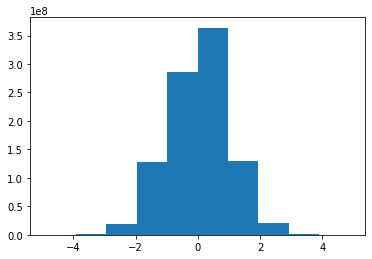

In [130]:
plt.hist(data[c].ravel())
# print(nib.load(row.fmri).header)

In [131]:
c = 'S'
dopair = False

data4isc = data[c]
# data4isc = gaussian_filter1d(data[c],2,axis=0)

In [132]:
data4isc.shape

(500, 189290, 10)

In [133]:
iscdata = {}
iscstat = {}

iscstat[c] = {}

iscdata[c] = isc(data4isc, pairwise=dopair)
iscdata[c][np.isnan(iscdata[c])] = 0

/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/brainiak/utils/utils.py:994: RuntimeWarning: invalid value encountered in true_divide
  return numerator / denominator


In [134]:
iscstat[c]['m'],iscstat[c]['ci'],iscstat[c]['p'],iscstat[c]['d'] = bootstrap_isc(iscdata[c], n_bootstraps=10000, pairwise=dopair)

In [135]:
tres_m = unmask(iscstat[c]['m'] * (iscstat[c]['p']<0.001),av_mask_img)


In [136]:
tres_mc, cl = filter_clusters(tres_m,50)

sizeof_hdr should be 348; set sizeof_hdr to 348


/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



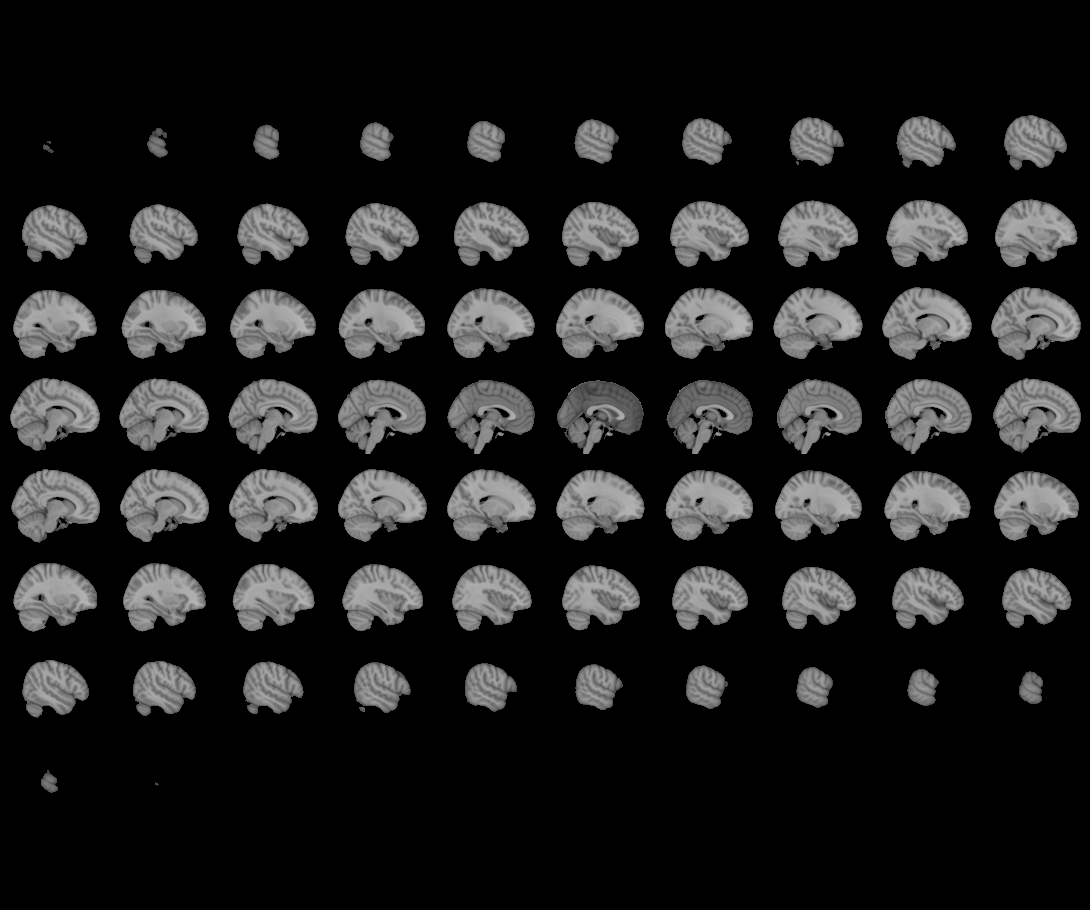
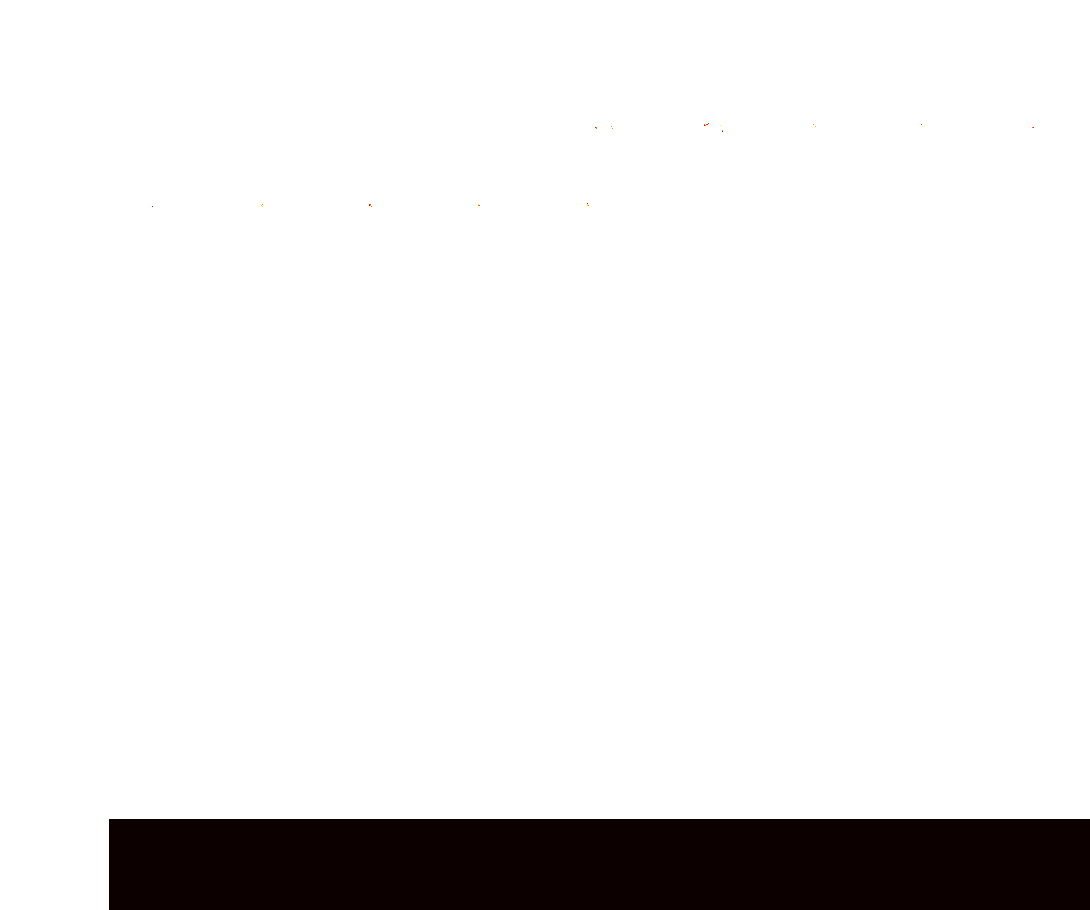

In [137]:
niplt.view_img(tres_mc)

In [138]:
pairstr = {True:'pair',False:'loo'}

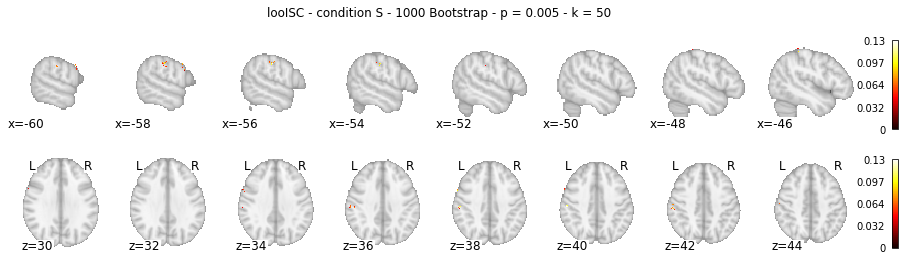

In [139]:
fig,axarr = plt.subplots(nrows = 2, figsize = (16,4))

a = niplt.plot_stat_map(tres_mc, display_mode = 'x', cut_coords=np.arange(-60,-44,2), axes = axarr[0])
niplt.plot_stat_map(tres_mc, display_mode = 'z', cut_coords=np.arange(30,46,2), axes = axarr[1])

fig.suptitle('{}ISC - condition {} - 1000 Bootstrap - p = 0.005 - k = 50'.format(pairstr[dopair],c))

plt.savefig(froot + 'iscdata/figs/{}ISC_{}.pdf'.format(pairstr[dopair],c), dpi = 600)

## Different approach (do not concatenate)

In [153]:
sub_av_isc = {}

for c in ['S','M']:

    all_isc = []
    for mov in data_mov_run[c]:
        for run in data_mov_run[c][mov]:
            single_isc = isc(data_mov_run[c][mov][run],pairwise=dopair)
            single_isc[np.isnan(single_isc)] = 0
            all_isc.append(single_isc)
            
    all_isc = np.array(all_isc)
    allm8_isc = np.delete(all_isc,4,axis = 1)
    
    sub_av_isc[c] = np.average(allm8_isc,axis = 1)
    

/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/brainiak/utils/utils.py:994: RuntimeWarning: invalid value encountered in true_divide
  return numerator / denominator


In [154]:
from scipy.stats import ttest_1samp,ttest_ind
from statsmodels.stats.multitest import fdrcorrection

In [155]:
isc_m.shape

(189290,)

In [157]:
isc_m,isc_p = ttest_ind(np.arctanh(sub_av_isc['M']),np.arctanh(sub_av_isc['S']),axis=0)
isc_pmask,isc_pcorr = fdrcorrection(isc_p,0.05)

/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/statsmodels/stats/multitest.py:325: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


In [174]:
isc_m,isc_p = ttest_1samp(np.arctanh(sub_av_isc['S']),0,axis=0)
isc_pmask,isc_pcorr = fdrcorrection(isc_p,0.05)

/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/statsmodels/stats/multitest.py:325: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


In [176]:
tres_m = unmask(isc_m * (isc_p < 0.005),av_mask_img)
tres_mc, cl = filter_clusters(tres_m,20)

/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
sizeof_hdr should be 348; set sizeof_hdr to 348


/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



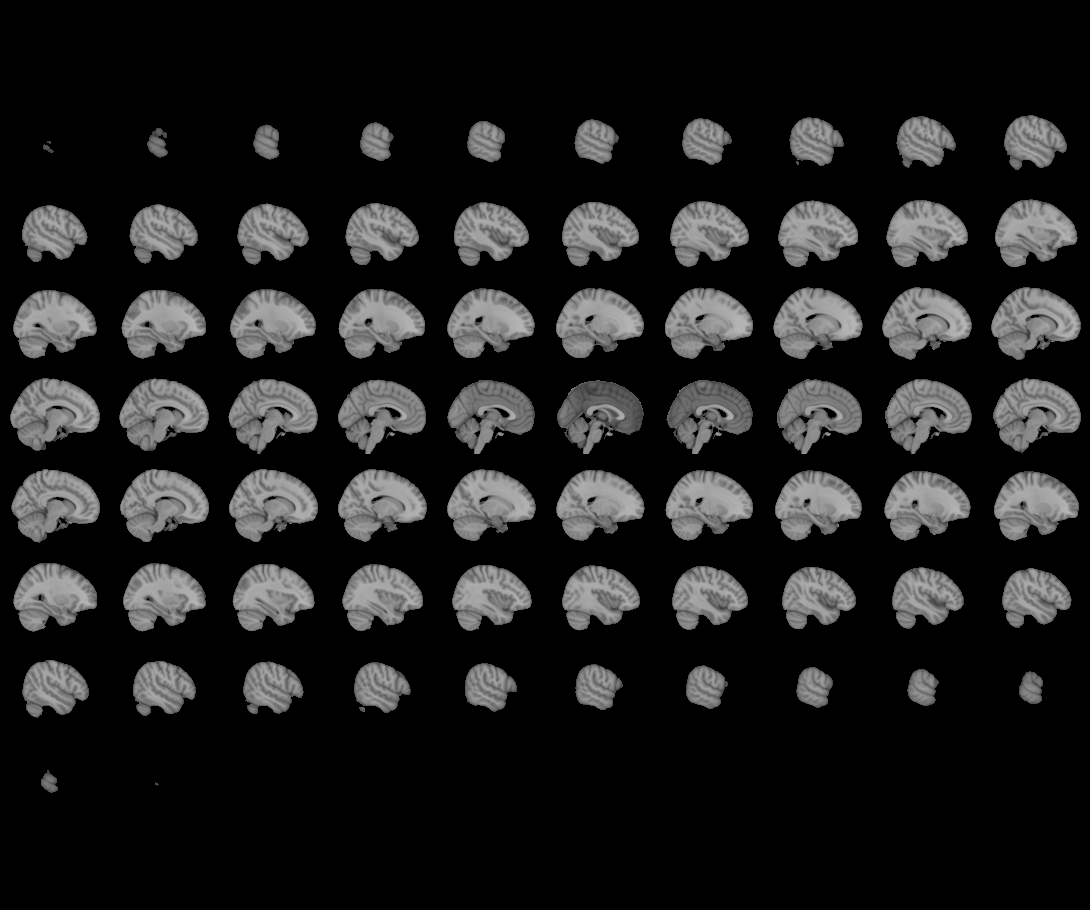
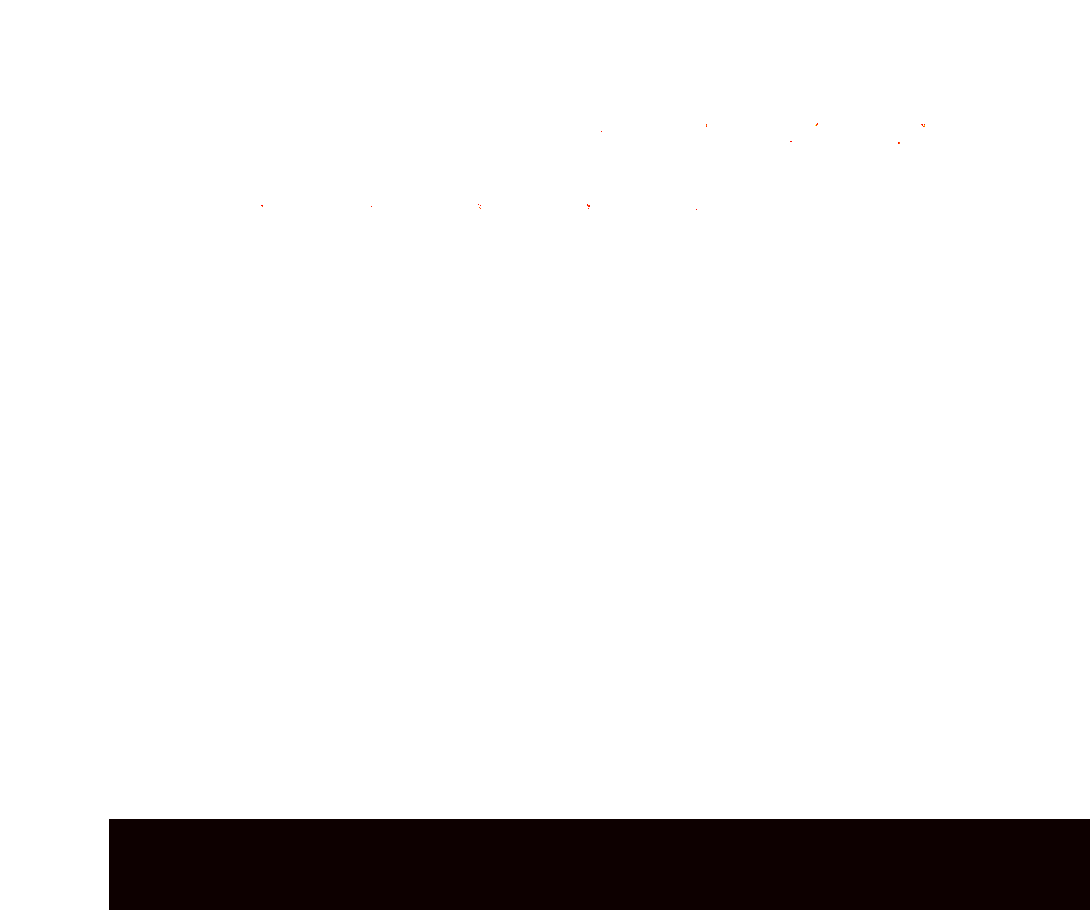

In [177]:
niplt.view_img(tres_mc)

/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


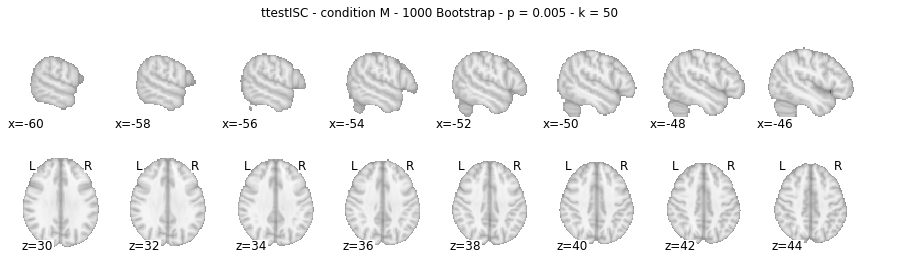

In [161]:
fig,axarr = plt.subplots(nrows = 2, figsize = (16,4))

a = niplt.plot_stat_map(tres_mc, display_mode = 'x', cut_coords=np.arange(-60,-44,2), axes = axarr[0])
niplt.plot_stat_map(tres_mc, display_mode = 'z', cut_coords=np.arange(30,46,2), axes = axarr[1])

fig.suptitle('ttestISC - condition {} - 1000 Bootstrap - p = 0.005 - k = 50'.format(c))

plt.savefig(froot + 'iscdata/figs/ttestISC_{}.pdf'.format(c), dpi = 600)

In [149]:
c

'S'

In [93]:
sub_av_isc.shape

(24, 189290)

In [64]:
nib.save(tres_mc,froot + 'iscdata/figs/{}ISC_{}.nii.gz'.format(pairstr[dopair],c))

In [65]:
nib.save(math_img('im > 0',im = tres_mc),froot + 'iscdata/figs/{}ISC_{}_bin.nii.gz'.format(pairstr[dopair],c))

In [151]:
from scipy.stats import ttest_1samp, ttest_ind
from statsmodels.stats.multitest import fdrcorrection

In [ ]:
iscstat[c]['m'],iscstat[c]['p'] = ttest_1samp(np.arctanh(iscdata[c]),0,axis=0)
iscstat[c]['pmask'],iscstat[c]['pcorr'] = fdrcorrection(iscstat[c]['p'],0.05)

In [ ]:
tres_m = unmask(iscstat[c]['m'] * (iscstat[c]['p'] < 0.005),av_mask_img)
tres_mc, cl = filter_clusters(tres_m,50)

In [ ]:
fig,axarr = plt.subplots(nrows = 2, figsize = (16,4))

a = niplt.plot_stat_map(tres_mc, display_mode = 'x', cut_coords=np.arange(-60,-44,2), axes = axarr[0])
niplt.plot_stat_map(tres_mc, display_mode = 'z', cut_coords=np.arange(30,46,2), axes = axarr[1])

fig.suptitle('ttestISC - condition {} - 1000 Bootstrap - p = 0.005 - k = 50'.format(c))

plt.savefig(froot + 'iscdata/figs/ttestISC_{}.pdf'.format(c), dpi = 600)

In [ ]:
mimg = unmask(iscstat[c]['m'] * (iscstat[c]['p']<0.001),av_mask_img)


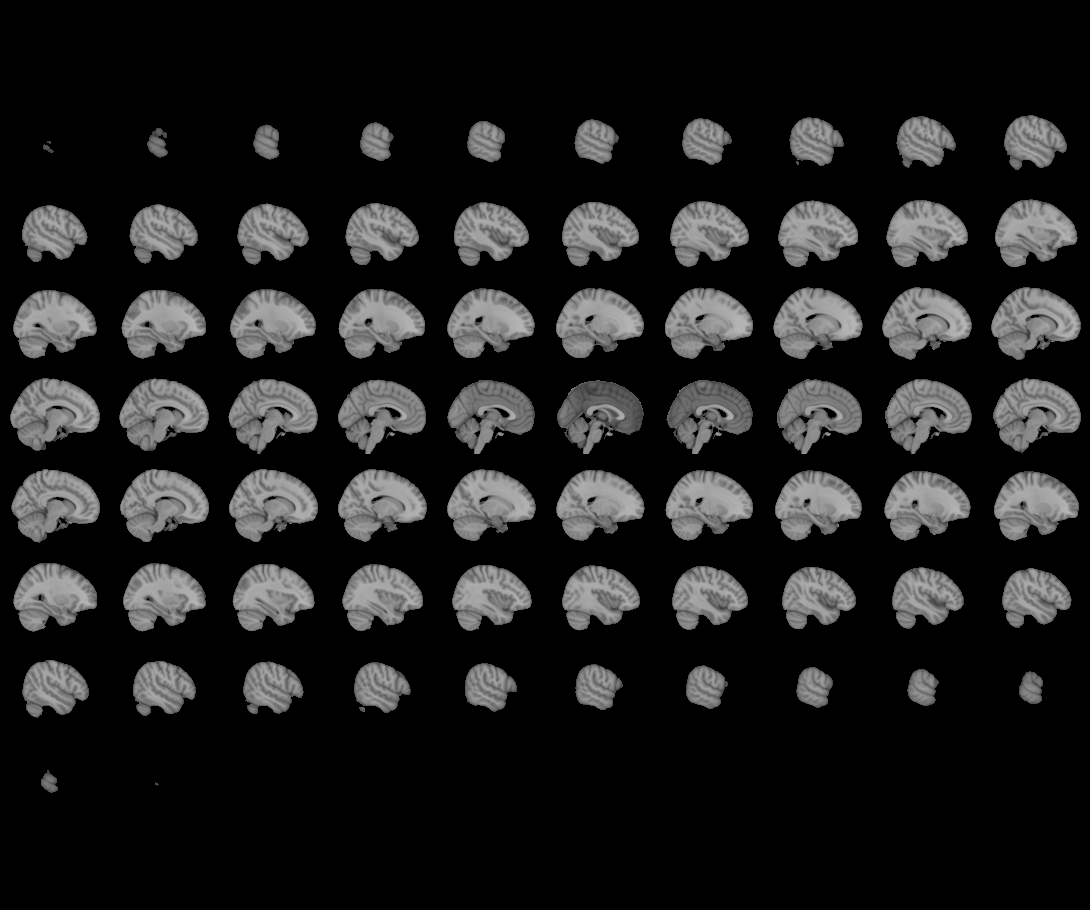
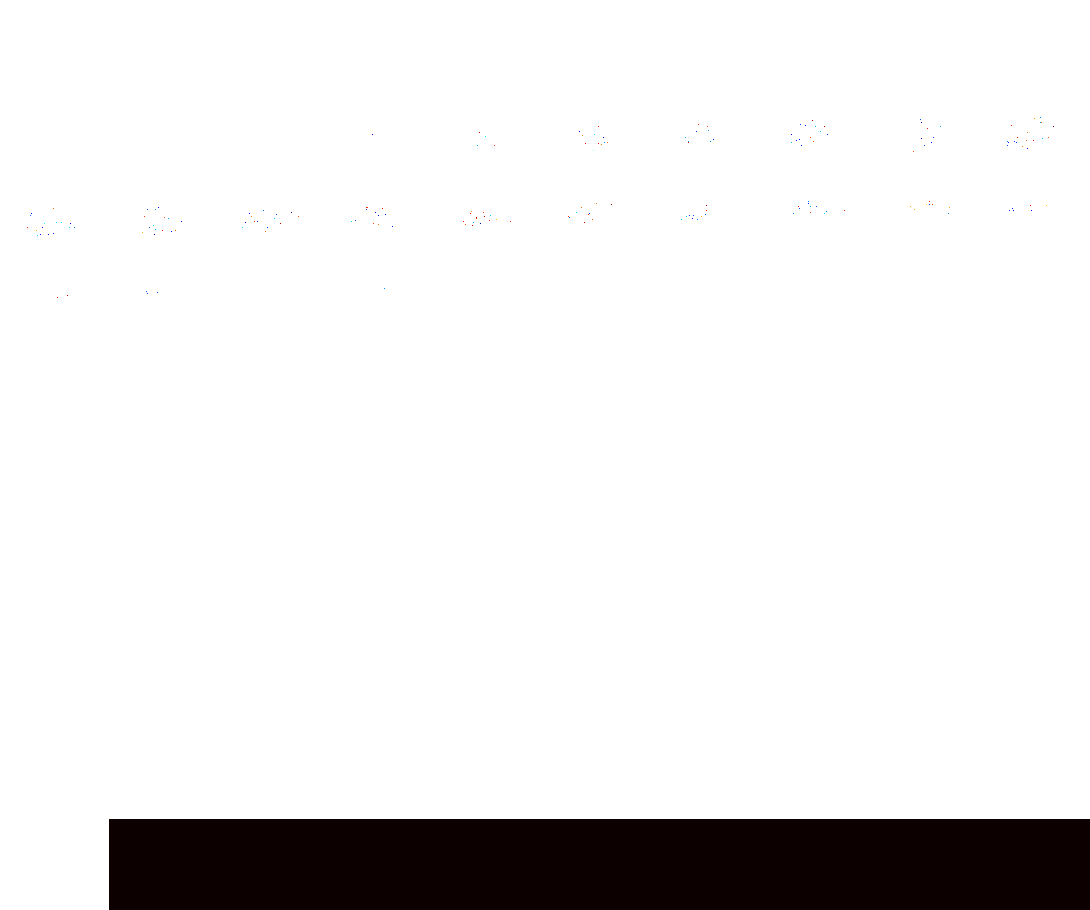

In [120]:
niplt.view_img(mimg)

(12, 79881)

In [19]:
### Make mask
masks = []
for f in logsumm['fmri'].values:

    m = nib.load(f.replace('_4D_MNI','_mean_brain_mask'))
    masks.append(m.get_fdata())
masks = np.array(masks)
av_mask = np.average(masks, axis = 0)

In [20]:
av_mask_img = nib.Nifti2Image(av_mask > 0, header = m.header, affine=m.affine)

sizeof_hdr should be 540; set sizeof_hdr to 540


In [21]:
nib.save(av_mask_img,froot + 'masks/average_mask_befpre.nii.gz')

In [22]:
av_mask_img_mni = resample_to_img(av_mask_img,logsumm['fmri'].iloc[0])

In [23]:
nib.save(av_mask_img_mni,froot + 'masks/average_mask_mni_befpre.nii.gz')

/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



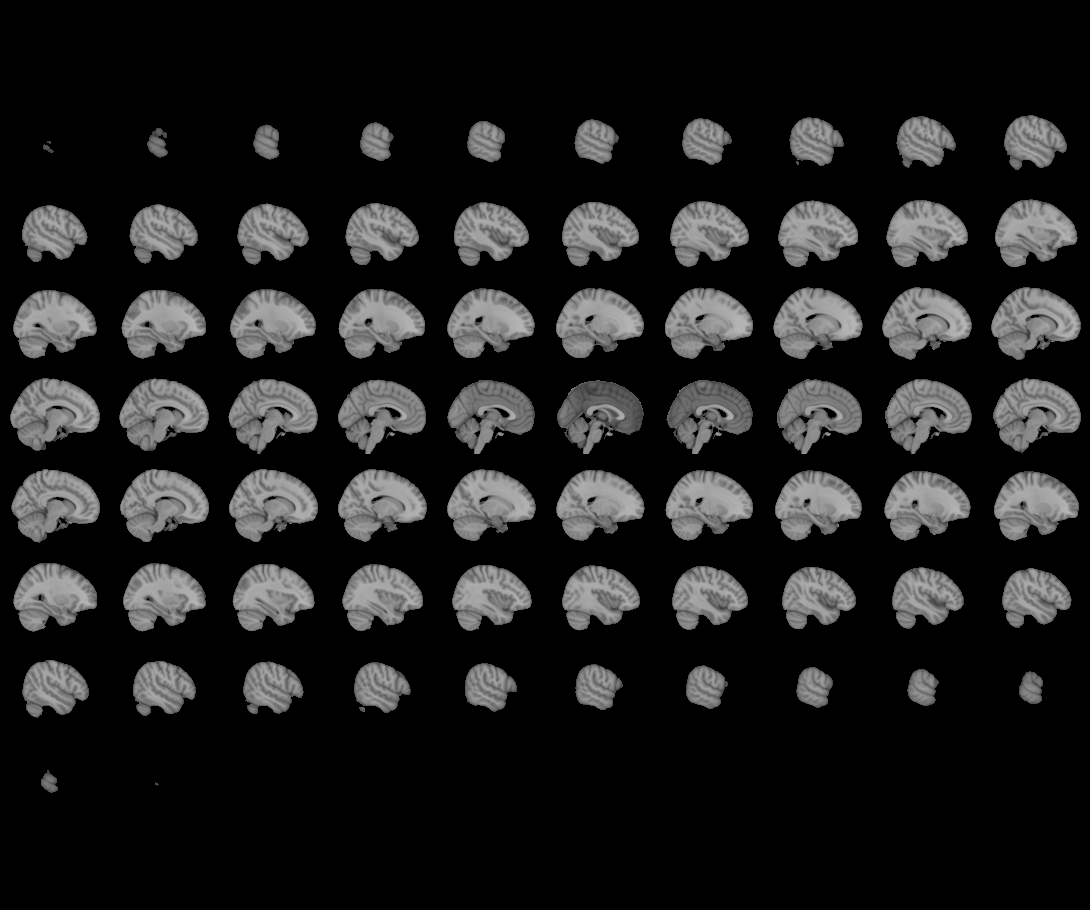
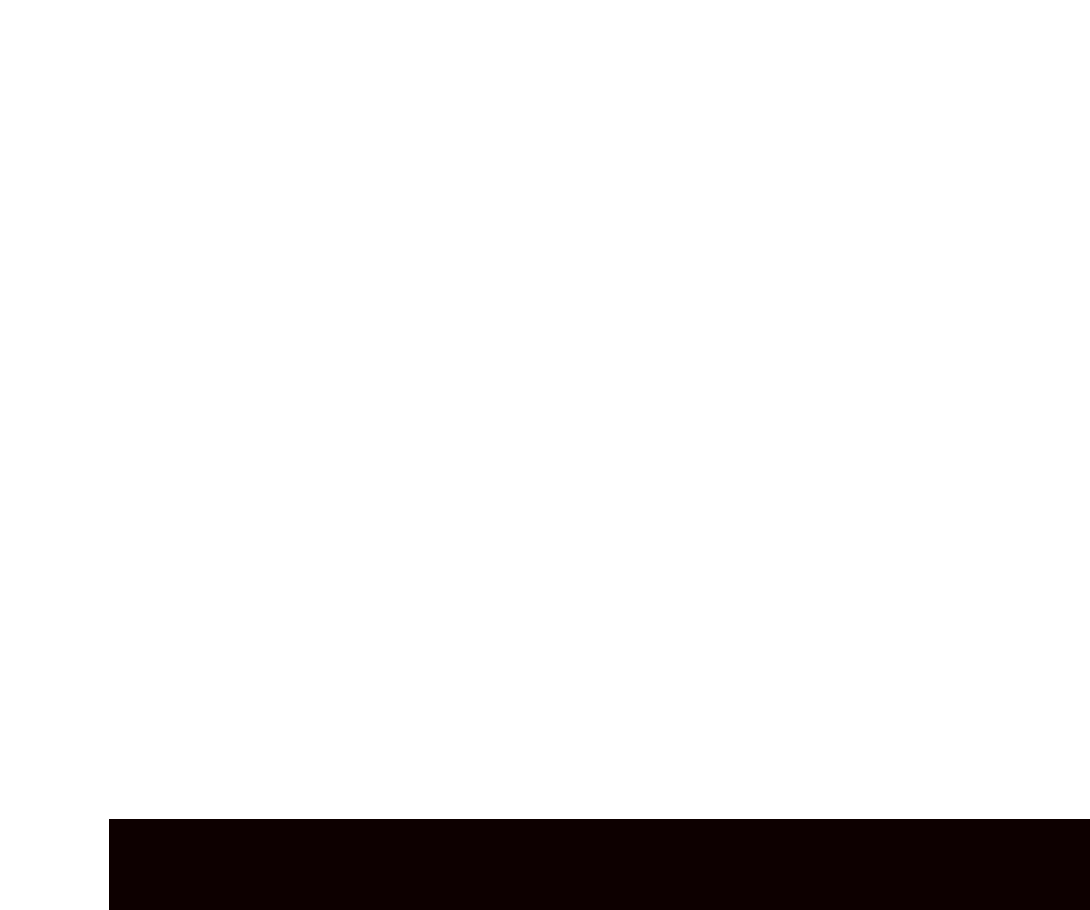

In [288]:
niplt.view_img(av_mask_img_mni)

In [27]:
def filter_clusters(thresholded_image,cluster_threshold):

    imgdata = np.nan_to_num(thresholded_image.get_fdata(),0)
    labeled = dolabel(imgdata != 0, background=0, connectivity = 2)
    labprops = regionprops(labeled)

    clusters = []
    for c in labprops:
        if c.area < cluster_threshold:
            labeled[labeled == c.label] = 0
        else:
            clusters.append([c.label,c.area])
        
    clusters = np.array(clusters)
    
    filtered_data = imgdata*(labeled > 0)
    filtered_image = nib.Nifti1Image(filtered_data,header=thresholded_image.header,affine=thresholded_image.affine)
    
    return filtered_image,clusters